In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import langdetect 
import nltk
import wordcloud
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
import collections
from sklearn import preprocessing, model_selection, feature_extraction, feature_selection, metrics, manifold, naive_bayes, pipeline
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from lime import lime_text
import shap
import gensim
import gensim.downloader as gensim_api
import transformers
import rouge
import difflib

2023-04-14 16:10:30.737526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 16:10:33.751988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/anaconda3/2022.05/lib:/shared/centos7/nodejs/14.15.4/lib:/home/patel.ayushj/.conda/envs/nlp-tf/lib/
2023-04-14 16:10:33.752215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos

In [3]:
data = pd.read_csv('Wikipedia-Level-4-Articles-Cleaned-2.csv')

In [4]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.head()

,Title,Article,Category,Summary,Article_clean,Summary_clean
0,Masaccio,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian decemb 1401 summer 1428 born ...,masaccio italian december 1401 summer 1428 bor...
1,Hokusai,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai octob 1760 may 1849 known s...,katsushika hokusai october 1760 may 1849 known...
2,Steven Spielberg,"Steven Allan Spielberg (; born December 18, 1...",People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born decemb 1946 americ...,steven allan spielberg born december 1946 amer...
3,Che Guevara,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 octob 19...,ernesto che guevara spanish june 1928 october ...
4,Jöns Jacob Berzelius,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzeliu swedish contemporari name...,baron jacob berzelius swedish contemporary nam...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10009 entries, 0 to 10008
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          10009 non-null  object
 1   Article        10009 non-null  object
 2   Category       10009 non-null  object
 3   Summary        10009 non-null  object
 4   Article_clean  10009 non-null  object
 5   Summary_clean  10009 non-null  object
dtypes: object(6)
memory usage: 469.3+ KB


In [6]:
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    data_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        data_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        data_n["ngrams"] = n
        data_freq = data_freq.append(data_n)
    data_freq["word"] = data_freq["word"].apply(lambda x: " ".join(string for string in x) )
    data_freq = data_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=data_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return data_freq

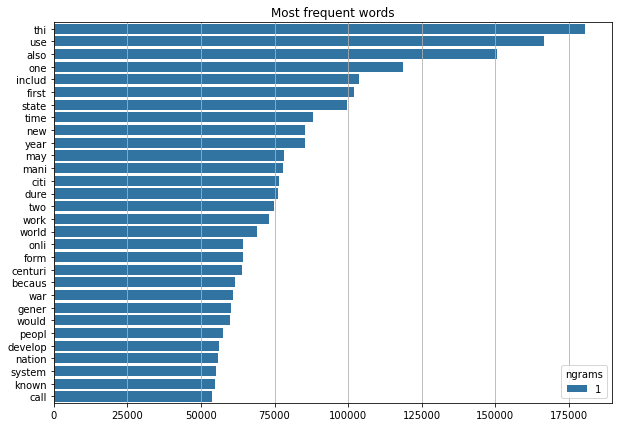

In [7]:
# Find most common words in article
data_freq = word_freq(corpus = data["Article_clean"], ngrams = [1], top = 30, figsize = (10,7))

In [8]:
thres = 5
X_top_words = len(data_freq[data_freq["freq"]>thres])
X_top_words

112845

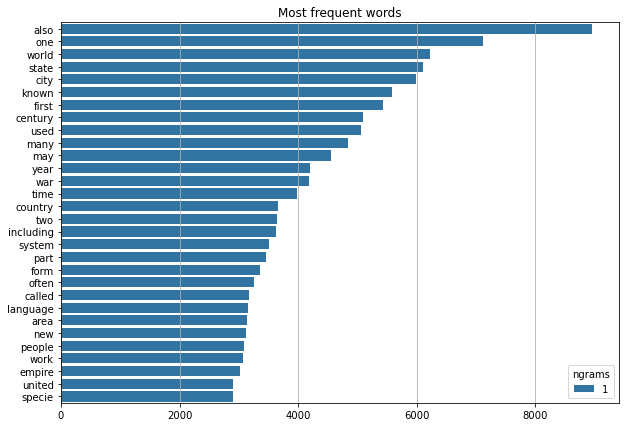

In [9]:
# Find most common words in summaries
data_freq = word_freq(corpus = data["Summary_clean"], ngrams = [1], top = 30, figsize = (10,7))

In [10]:
thres = 5
y_top_words = len(data_freq[data_freq["freq"] > thres])
y_top_words

21268

In [11]:
def add_text_length(data, column):
    data = data.copy()
    data['word_count'] = data[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
    data['char_count'] = data[column].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
    data['sentence_count'] = data[column].apply(lambda x: len(nltk.sent_tokenize(str(x))) )
    data['avg_word_length'] = data['char_count'] / data['word_count']
    data['avg_sentence_lenght'] = data['word_count'] / data['sentence_count']
    print(data[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return data

In [12]:
# Texts
X = add_text_length(data, "Article_clean")

                            min          mean           max
char_count           421.000000  19482.671296  126076.00000
word_count            60.000000   3371.737236   21625.00000
sentence_count         1.000000      1.000000       1.00000
avg_word_length        4.719607      5.786694       8.22809
avg_sentence_lenght   60.000000   3371.737236   21625.00000


In [13]:
def plot_distributions(data, x, max_cat=20, top=None, y=None, bins=None, figsize=(10,5)):
    ## univariate
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        ### categorical
        if data[x].nunique() <= max_cat:
            if top is None:
                data[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            else:   
                data[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            ax.set(ylabel=None)
        ### numerical
        else:
            sns.distplot(data[x], hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
            ax.grid(True)
            ax.set(xlabel=None, yticklabels=[], yticks=[])

    ## bivariate
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in data[y].unique():
            sns.distplot(data[data[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(data[data[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(data[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()

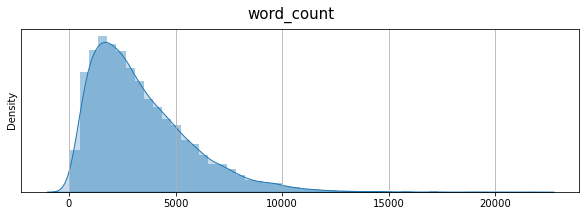

In [14]:
plot_distributions(X, x = "word_count", figsize = (10,3))

In [15]:
def add_text_length(data, column):
    data = data.copy()
    data['word_count'] = data[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
    data['char_count'] = data[column].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
    data['sentence_count'] = data[column].apply(lambda x: len(nltk.sent_tokenize(str(x))) )
    data['avg_word_length'] = data['char_count'] / data['word_count']
    data['avg_sentence_lenght'] = data['word_count'] / data['sentence_count']
    print(data[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return data

In [16]:
# Summaries
y = add_text_length(data, "Summary_clean")

                           min         mean          max
char_count           43.000000  1115.091118  7475.000000
word_count            8.000000   164.608552  1133.000000
sentence_count        1.000000     1.000000     1.000000
avg_word_length       4.611111     6.777615     9.566667
avg_sentence_lenght   8.000000   164.608552  1133.000000


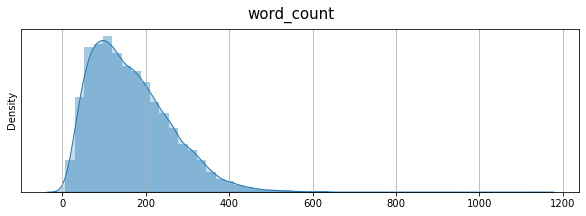

In [17]:
plot_distributions(y, x = "word_count", max_cat = 1, figsize = (10,3))

In [18]:
data = data[["Title","Category","Article","Article_clean","Summary","Summary_clean"]]
data.head()

,Title,Category,Article,Article_clean,Summary,Summary_clean
0,Masaccio,People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian decemb 1401 summer 1428 born ...,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian december 1401 summer 1428 bor...
1,Hokusai,People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai octob 1760 may 1849 known s...,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai october 1760 may 1849 known...
2,Steven Spielberg,People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born decemb 1946 americ...,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born december 1946 amer...
3,Che Guevara,People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 octob 19...,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 october ...
4,Jöns Jacob Berzelius,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzeliu swedish contemporari name...,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzelius swedish contemporary nam...


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10009 entries, 0 to 10008
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          10009 non-null  object
 1   Category       10009 non-null  object
 2   Article        10009 non-null  object
 3   Article_clean  10009 non-null  object
 4   Summary        10009 non-null  object
 5   Summary_clean  10009 non-null  object
dtypes: object(6)
memory usage: 469.3+ KB


In [20]:
# Partitioning
data_train = data[0:5000]
data_test = data[5001:7686]

In [21]:
data_train.head()

,Title,Category,Article,Article_clean,Summary,Summary_clean
0,Masaccio,People,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian decemb 1401 summer 1428 born ...,"Masaccio (UK: , US: , Italian: [maˈzattʃo]; De...",masaccio italian december 1401 summer 1428 bor...
1,Hokusai,People,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai octob 1760 may 1849 known s...,"Katsushika Hokusai (葛飾 北斎, c. 31 October 1760 ...",katsushika hokusai october 1760 may 1849 known...
2,Steven Spielberg,People,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born decemb 1946 americ...,"Steven Allan Spielberg (; born December 18, 1...",steven allan spielberg born december 1946 amer...
3,Che Guevara,People,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 octob 19...,"Ernesto ""Che"" Guevara (Spanish: [ˈtʃe ɣeˈβaɾa]...",ernesto che guevara spanish june 1928 october ...
4,Jöns Jacob Berzelius,People,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzeliu swedish contemporari name...,Baron Jöns Jacob Berzelius (Swedish: [jœns ˈjɑ...,baron jacob berzelius swedish contemporary nam...


In [22]:
data_test.head()

,Title,Category,Article,Article_clean,Summary,Summary_clean
5001,Manta ray,Biology_and_health_sciences,Manta rays are large rays belonging to the gen...,manta ray larg ray belong genu mobula formerli...,Manta rays are large rays belonging to the gen...,manta ray large ray belonging genus mobula for...
5002,Tagetes,Biology_and_health_sciences,Tagetes () is a genus of 50 species of annual...,taget genu speci annual perenni mostli herbac ...,Tagetes () is a genus of 50 species of annual...,tagetes genus specie annual perennial mostly h...
5003,Seaweed,Biology_and_health_sciences,"Seaweed, or macroalgae, refers to thousands of...",seawe macroalga refer thousand speci macroscop...,"Seaweed, or macroalgae, refers to thousands of...",seaweed macroalgae refers thousand specie macr...
5004,Fungus,Biology_and_health_sciences,A fungus (PL: fungi or funguses) is any member...,fungu fungi fungus ani member group eukaryot o...,A fungus (PL: fungi or funguses) is any member...,fungus fungi fungus member group eukaryotic or...
5005,Kiwi (bird),Biology_and_health_sciences,Kiwi ( KEE-wee) are flightless birds endemic t...,kiwi keewe flightless bird endem new zealand o...,Kiwi ( KEE-wee) are flightless birds endemic t...,kiwi keewee flightless bird endemic new zealan...


In [23]:
def textrank(corpus, ratio=0.2):
    if type(corpus) is str:
        corpus = [corpus]
    lst_summaries = [gensim.summarization.summarize(txt, ratio=ratio) for txt in corpus]
    return lst_summaries

In [24]:
y_len = 40
X_len = 400

In [25]:
# Test (no Train)
predicted = textrank(corpus = data_test["Article"], ratio = y_len / X_len)

In [26]:
def evaluate_summary(y_test, predicted):
    rouge_score = rouge.Rouge()
    scores = rouge_score.get_scores(y_test, predicted, avg=True)
    score_1 = round(scores['rouge-1']['f'], 2)
    score_2 = round(scores['rouge-2']['f'], 2)
    score_L = round(scores['rouge-l']['f'], 2)
    print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:", score_2, 
          "--> avg rouge:", round(np.mean([score_1,score_2,score_L]), 2))

In [27]:
act = data_test.iloc[0]["Summary"]

In [28]:
pred = predicted[0]

In [29]:
# Evaluate
evaluate_summary(act, pred)

rouge1: 0.32 | rouge2: 0.13 | rougeL: 0.13 --> avg rouge: 0.25


In [30]:
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [31]:
# Compare y_test and predicted
match = display_string_matching(act, pred, both = True, sentences = False, 
                                titles = ["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

In [32]:
def utils_split_sentences(a, b):
    # find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    # difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    # work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b

In [33]:
# Explainability
match = display_string_matching(act, pred, both = True, sentences = True, 
                                titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))